Análisis y Visualización de Procesos Estocásticos ARMA: ACF, PACF y Espectros
=============================================================================

**Author:** Marcos Bujosa



Al final del documento aparece el código fuente de algunos programas que usaré  para crear el material de clase correspondiente al análisis de modelos ARMA. 

Veamos algunos ejemplos de lo que obtenemos con dichos programas:



In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
%run -i analisis_armas.py

## ACF, PACF y densidad espectral teóricas



### Ruido blanco



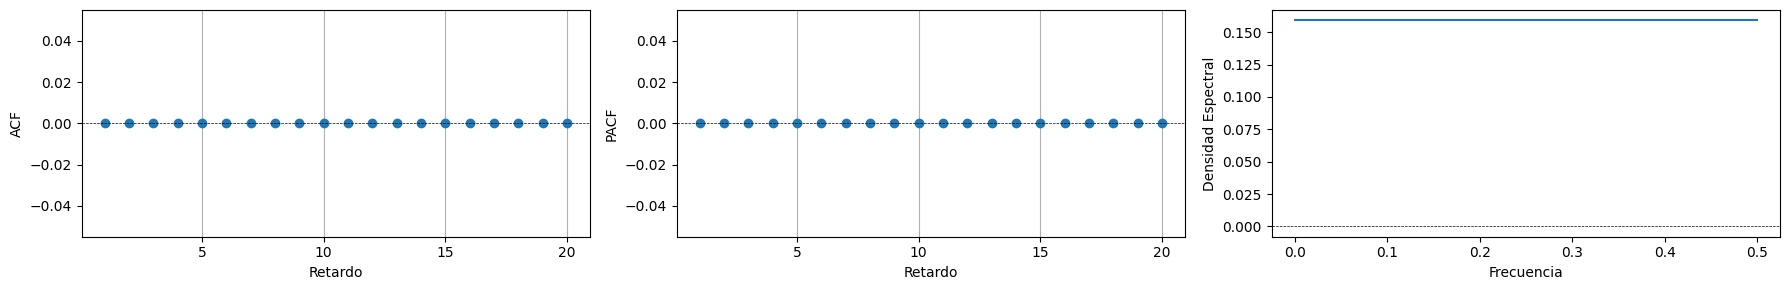

In [2]:
ar_params = [1,]
ma_params = [1,]
plot_arma_parametric_diagnostics(ar_params, ma_params)

## ACF, PACF y densidad espectral estimadas de un modelo simulado



### Ruido blanco



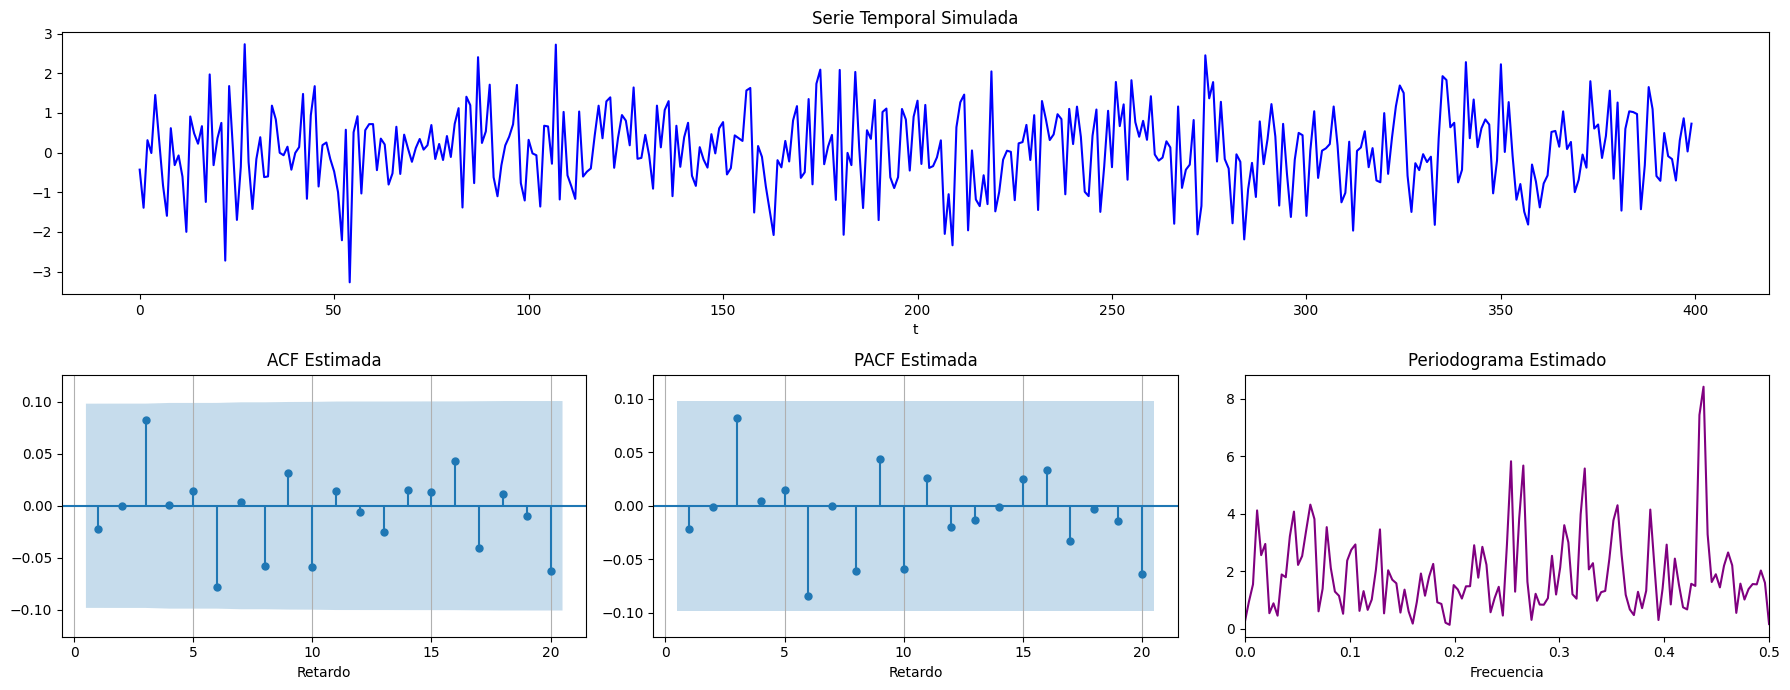

In [3]:
plot_arma_analysis(ar_params, ma_params, seed=2026)

## Análisis de un modelo ARMA



### ACF, PACF y densidad espectral teóricas



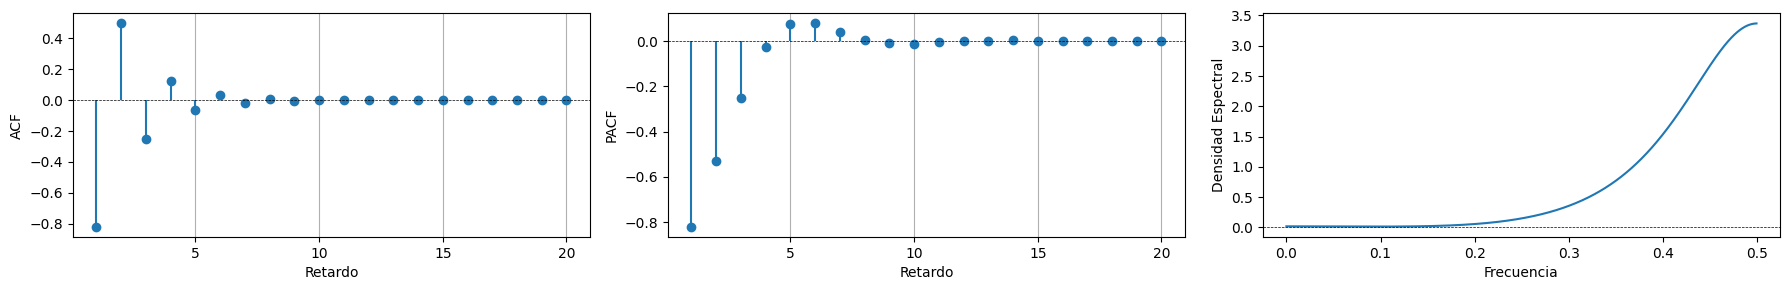

In [4]:
ar_params = [1, 0.5]
ma_params = [1, -0.9, 0.4]
plot_arma_parametric_diagnostics(ar_params, ma_params)

### Simulación del modelo, estimación de las ACF y PACF muestrales y cálculo del periodograma



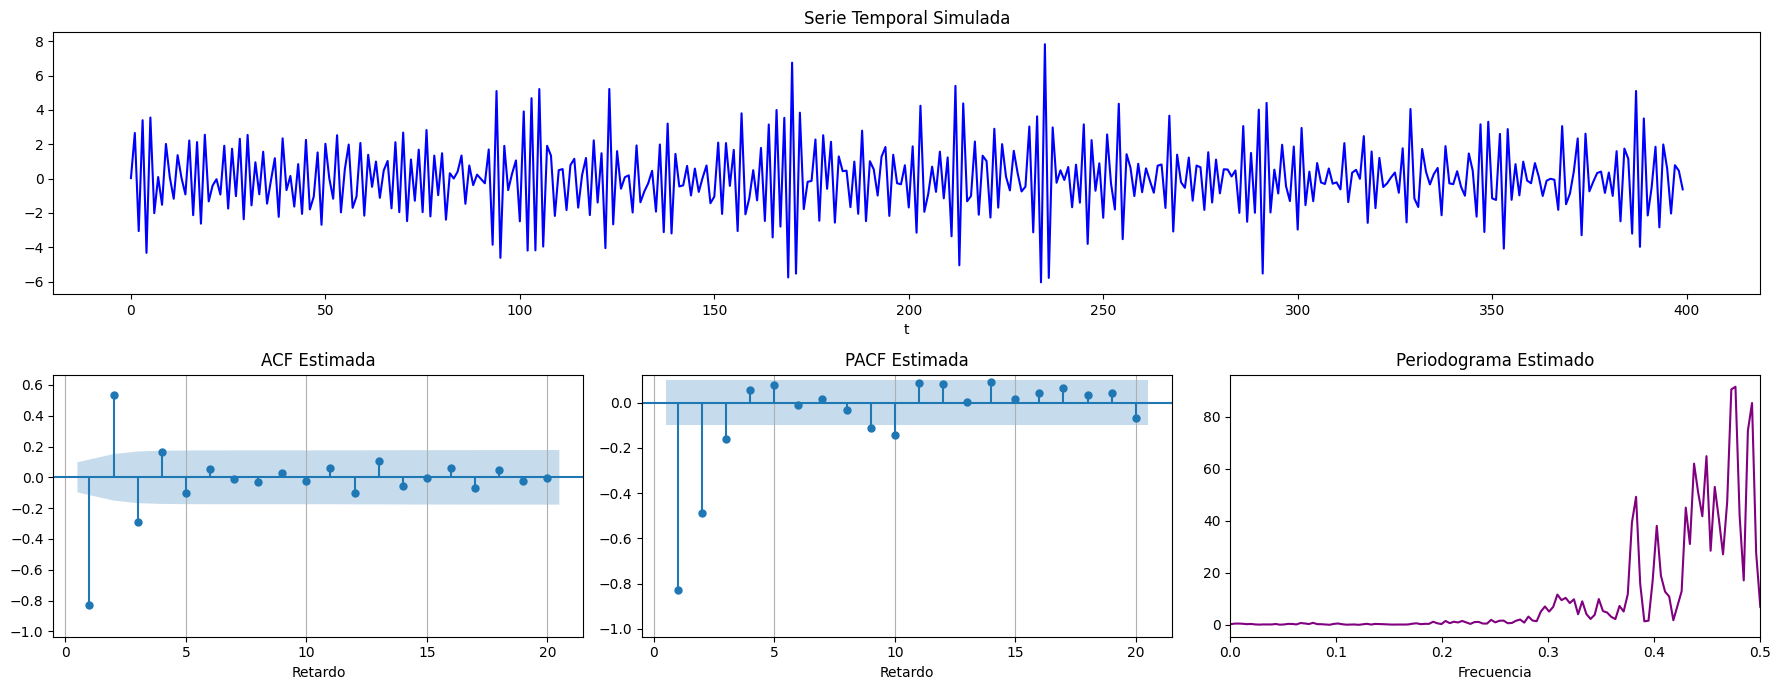

In [5]:
plot_arma_analysis(ar_params, ma_params)

#### Caso paseo aleatorio



Paseo aleatorio con deriva



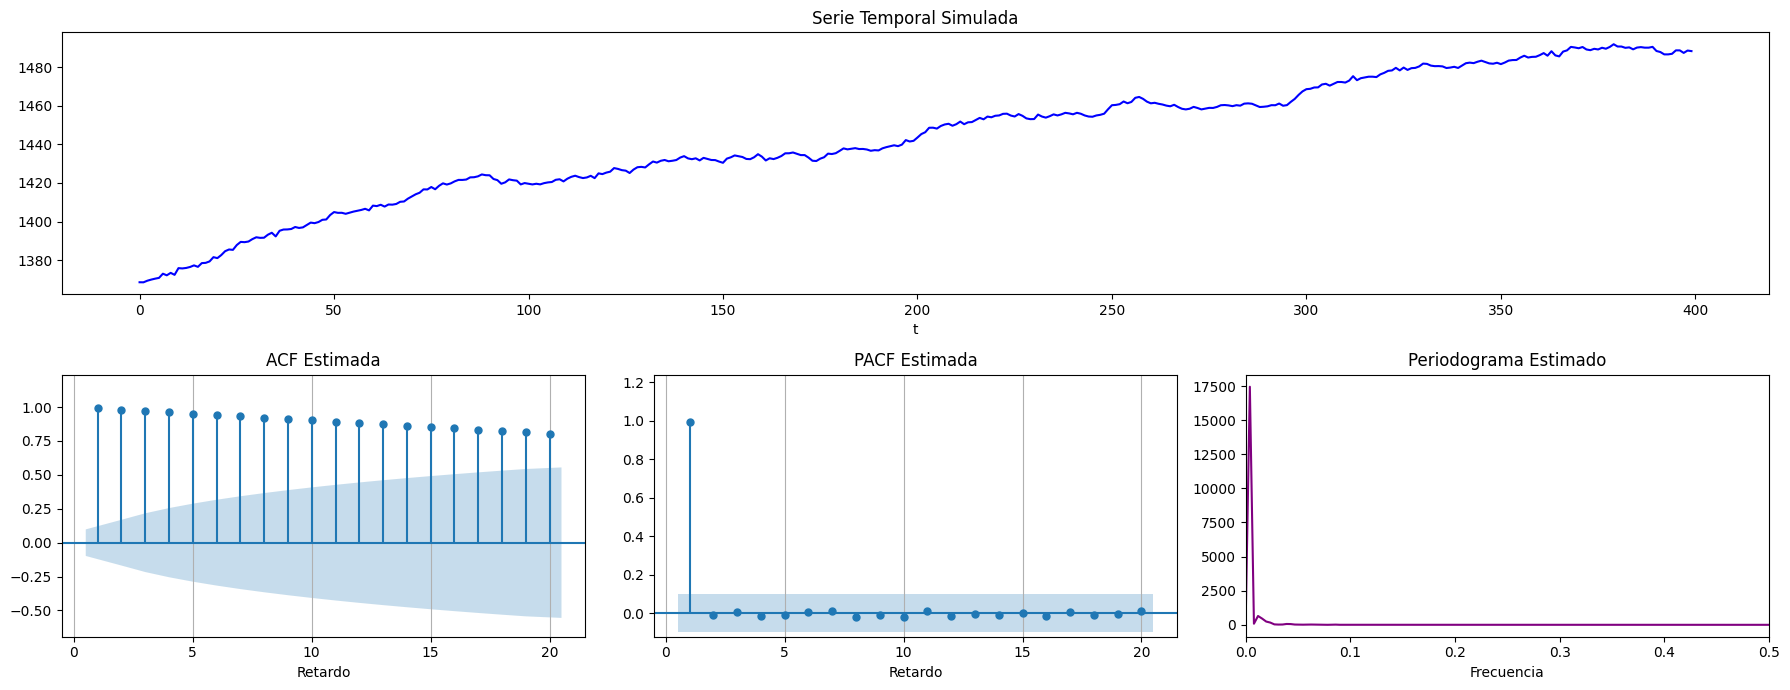

In [6]:
plot_paseo_aleatorio_analysis(trend="t", pendiente=0.25, n=400, semilla=2025)

Paseo aleatorio sin deriva



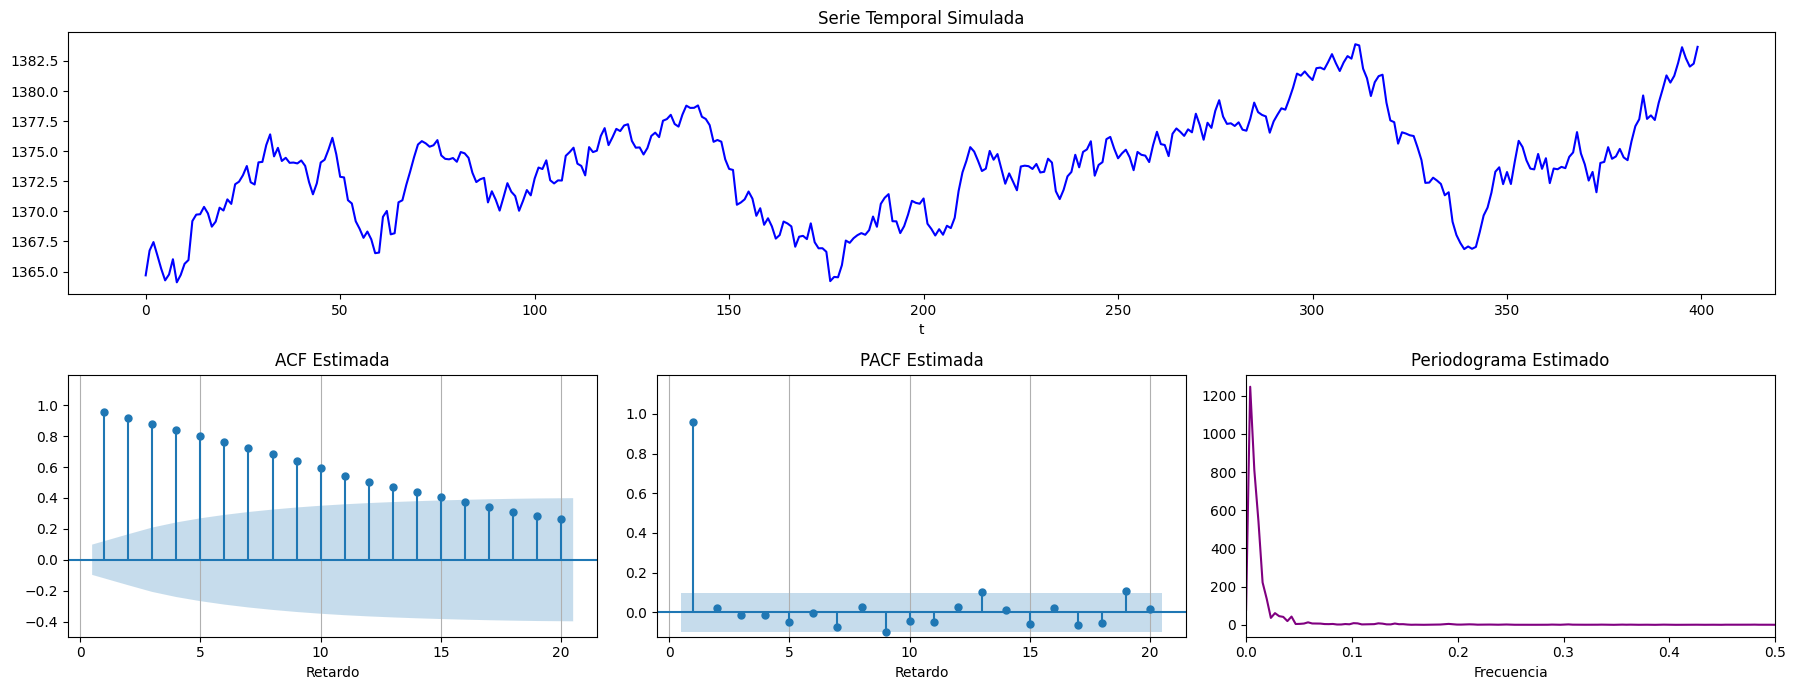

In [7]:
plot_paseo_aleatorio_analysis(n=400, semilla=2026)

#### Caso ARMA estacional



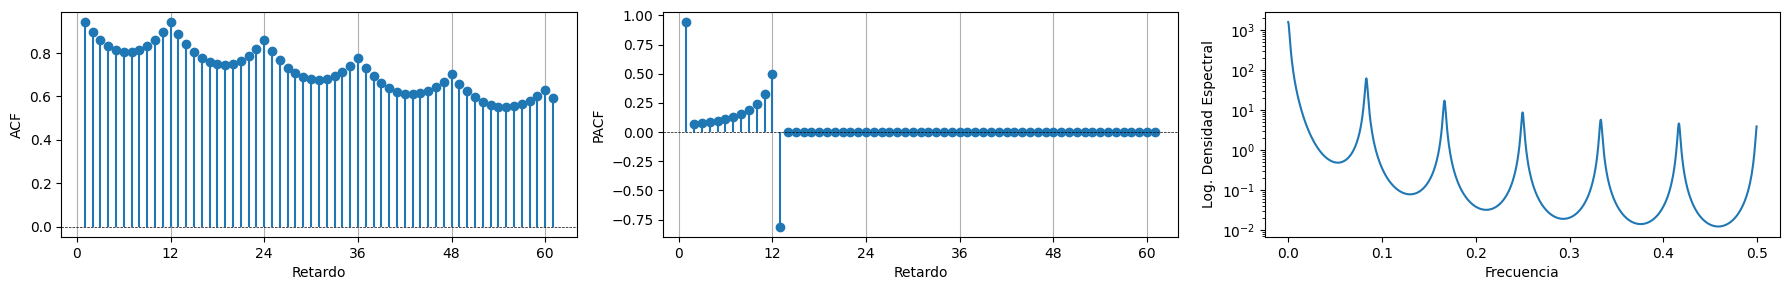

In [8]:
plot_arma_seasonal_parametric_diagnostics(ar_params=[1, -0.9], s=12, seasonal_ar_params=[1, -0.9], logs=True)

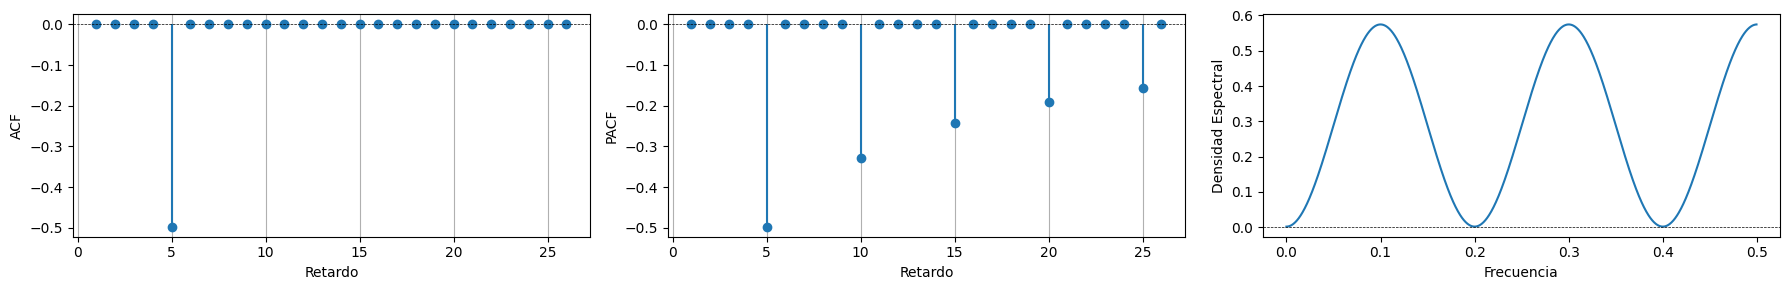

In [9]:
plot_arma_seasonal_parametric_diagnostics(seasonal_ma_params=[1, -0.9])

### Raíces de uno de los polinomos



In [10]:
ar_params = [1, -0.9, 0.4]
polynomial_roots_table(ar_params)

,P. real,P. imag.,Módulo,Frecuencia,Periodo,Multip.
0,1.125,-1.111024,1.581139,0.124005,8.064174,1
1,1.125,1.111024,1.581139,0.124005,8.064174,1


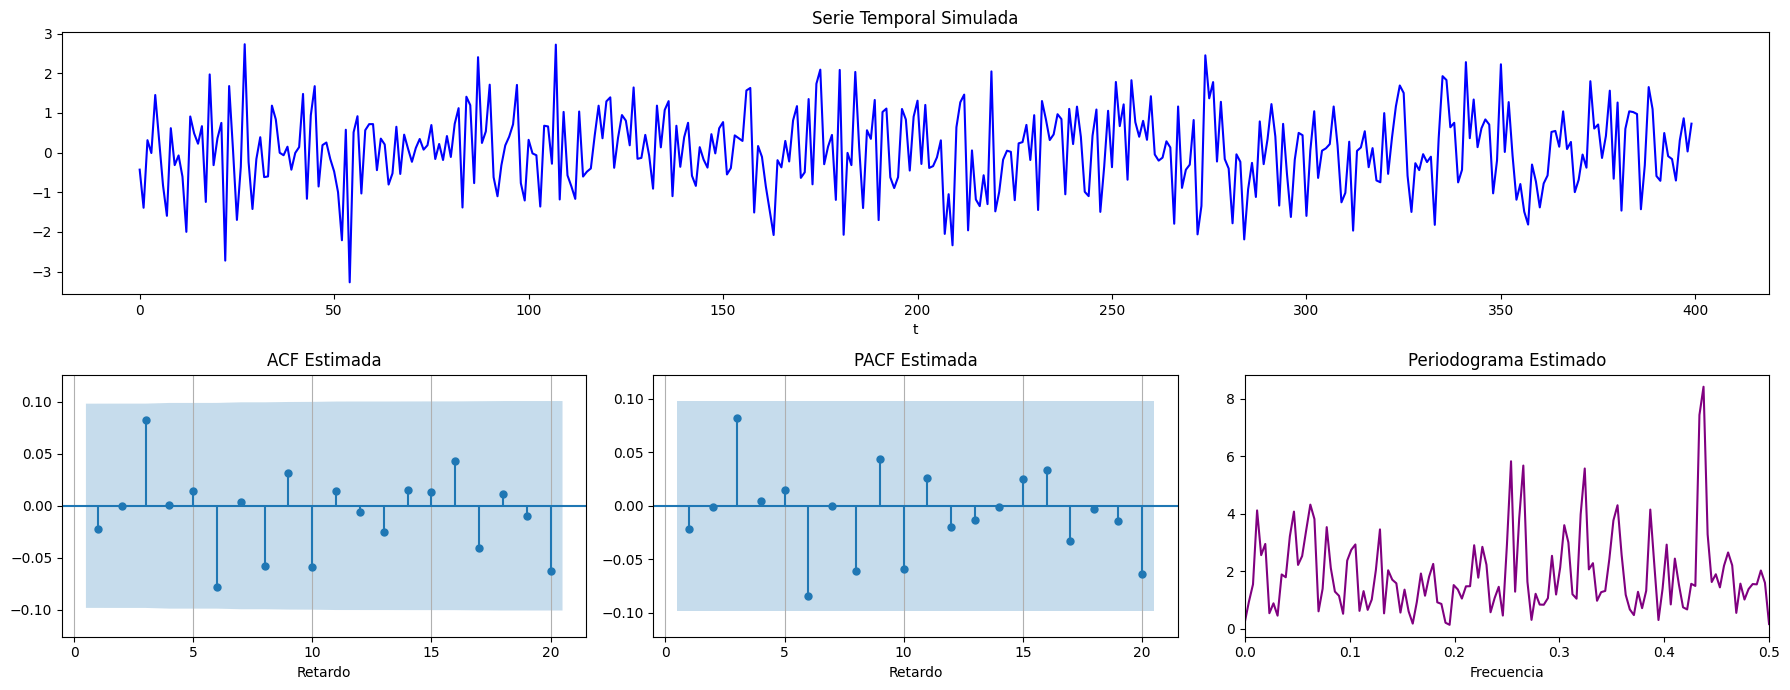

In [11]:
plot_arma_analysis(ar_params, ma_params)

## Ejemplo de uso



In [12]:
ma_params = [1, -1.5, 0.54]
#ma_params = [1, -1, 0.25]
#ma_params = [1, -1, 0.35]
#ma_params = [1, -1, 0]
#ma_params = [1, 0, 1]

polynomial_roots_table(ma_params)

,P. real,P. imag.,Módulo,Frecuencia,Periodo,Multip.
0,1.111111,0.0,1.111111,0.0,Inf,1
1,1.666667,0.0,1.666667,0.0,Inf,1


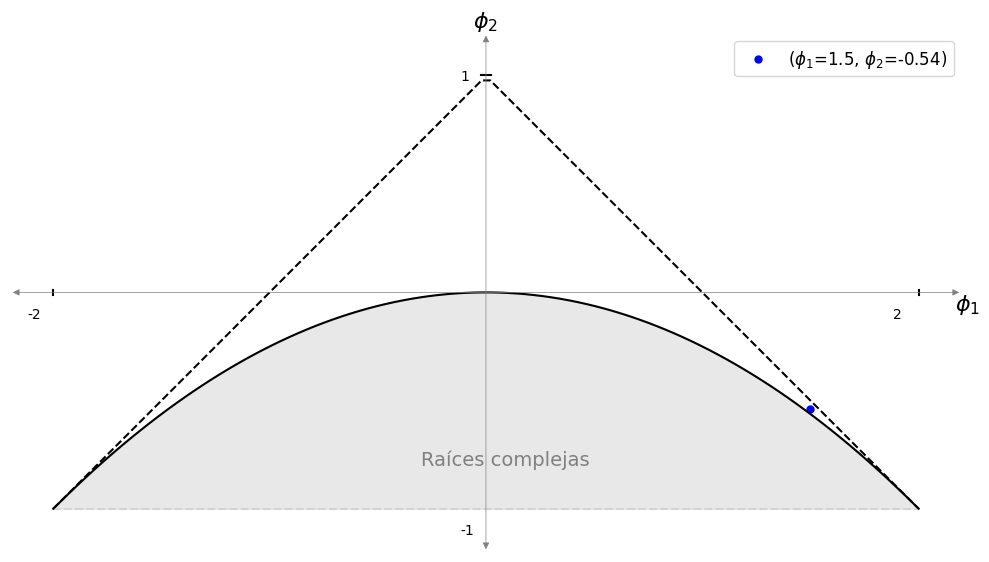

In [13]:
Localizacion_parametros_plot(-ma_params[1],-ma_params[2],'AR')

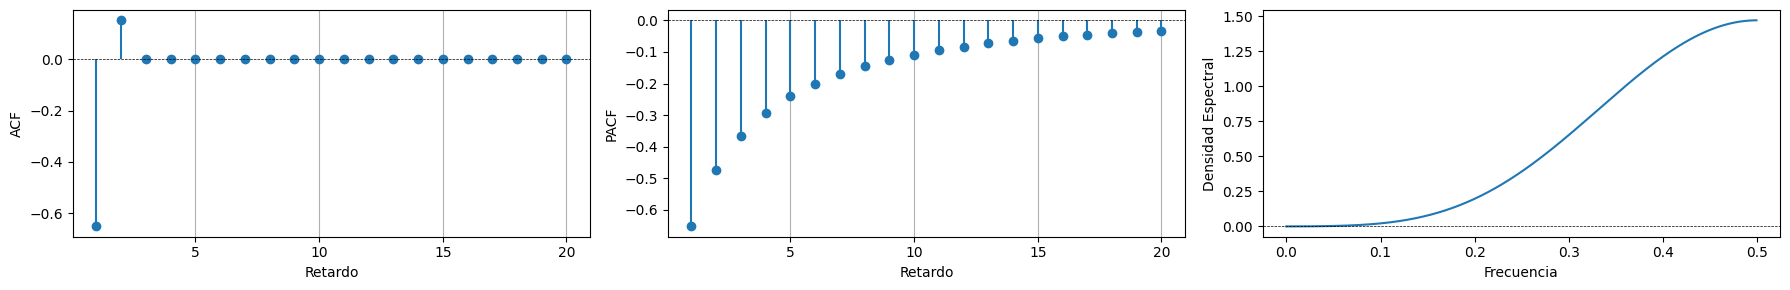

In [14]:
plot_arma_parametric_diagnostics([1], ma_params)

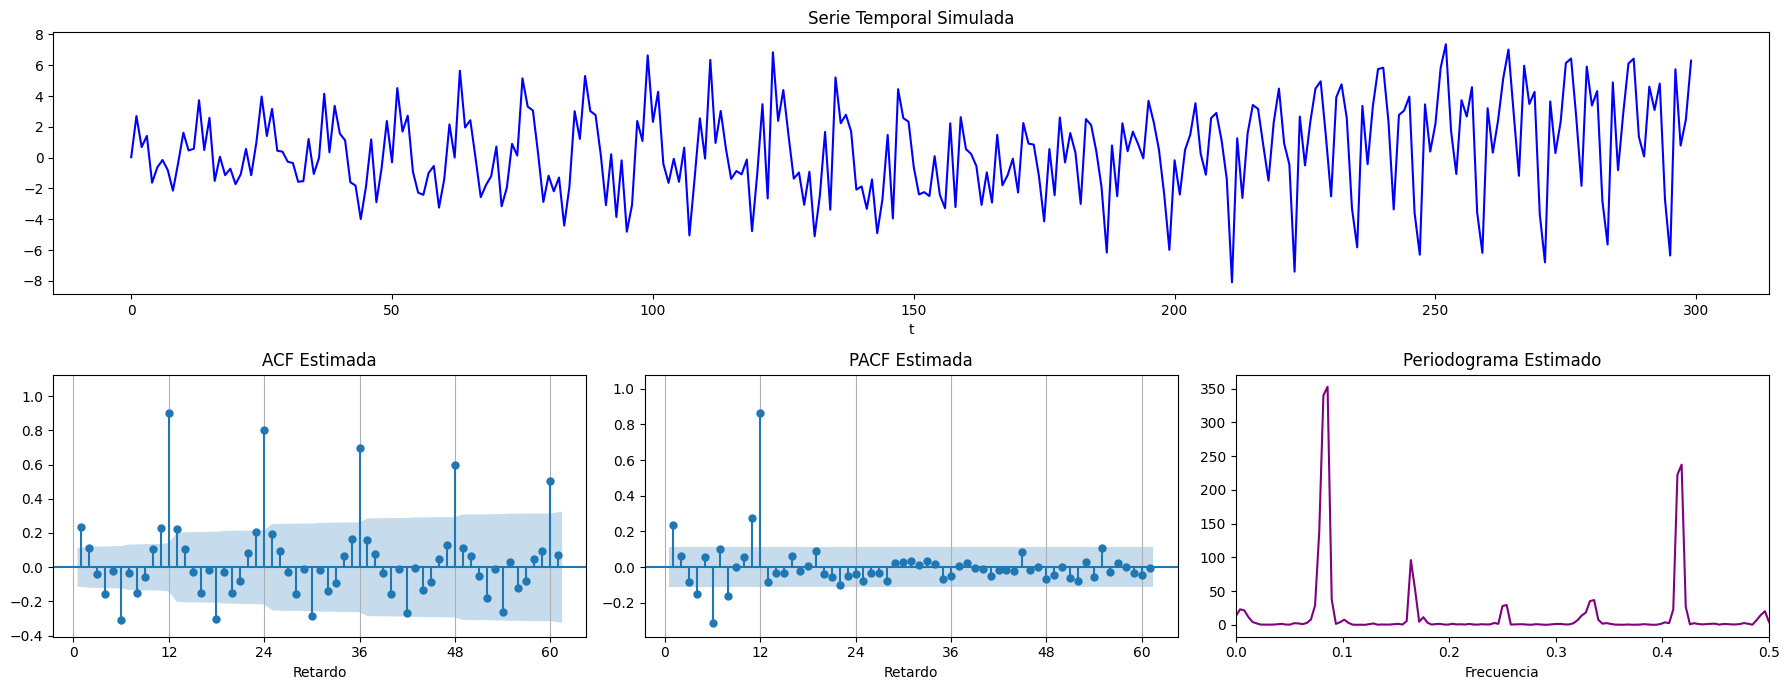

In [15]:
plot_sarima_analysis(seasonal_ar_params=[1,],d=0, ar_params=[1,],D=1,s=12,n=300)

## Código en python



Éstas son las librerías empleadas en las funciones de más abajo:

    import numpy as np
    from numpy.polynomial import Polynomial
    
    import pandas as pd
    
    import matplotlib as mpl
    # definimos parámetros para mejorar los gráficos
    mpl.rc('text', usetex=False)
    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker ## *** nuevo para ARMAs estacionales
    
    import statsmodels.api as sm
    from statsmodels.tsa.arima_process import ArmaProcess
    from statsmodels.tsa.arima.model import ARIMA ## *** nuevo en paseos aleatorios
    
    from scipy import signal
    from scipy.signal import freqz
    
    import math



### Cálculo de la PACF a partir de la ACF (`theoretical_pacf_from_acf`)



La siguiente función calcula la PACF a partir de la ACF resolviendo las [ecuaciones de Yule-Walker](./Lecc05.html#org392fab2) recursivamente con el algoritmo [Levinson-Durbin](https://en.wikipedia.org/wiki/Levinson_recursion); véase *Pourahmadi, M. (2001, Capítulo 7)* o *Brockwell & Davis (1991, Capítulo 5)*). 

    def theoretical_pacf_from_acf(acf_vals):
        """
        Calcula la PACF teórica (para lags >= 0) de forma paramétrica usando el algoritmo de Durbin-Levinson.
    
        Parámetros:
          acf_vals (list):
              una lista tal que acf_vals[0] corresponde al retardo 0.
        
        Retorna:
          list: el coeficiente en la posición k corresponde a la PACF en el retardo k.
        """
        nlags = len(acf_vals)-1
        # Matriz para almacenar los coeficientes (phi)
        phi = np.zeros((nlags+1, nlags+1))
        # v guarda la varianza de error en cada paso
        v = np.zeros(nlags+1)
        pacf = np.zeros(nlags+1)
        v[0] = acf_vals[0]
        pacf[0] = 1.0  # Por convención, PACF(0)=1.
        
        for k in range(1, nlags+1):
            if k == 1:
                phi[1,1] = acf_vals[1] / acf_vals[0]
                pacf[1] = phi[1,1]
                v[1] = v[0]*(1 - phi[1,1]**2)
            else:
                sum_val = 0.0
                # Sumar phi[k-1,j]*acf_vals[k-j] para j=1,...,k-1.
                for j in range(1, k):
                    sum_val += phi[k-1, j] * acf_vals[k - j]
                phi[k, k] = (acf_vals[k] - sum_val) / v[k-1]
                pacf[k] = phi[k, k]
                for j in range(1, k):
                    phi[k, j] = phi[k-1, j] - phi[k, k] * phi[k-1, k - j]
                v[k] = v[k-1] * (1 - phi[k, k]**2)
        return pacf  # Incluye PACF en lag 0 con valor 1.



### Representación de la ACF, PACF y densidad espectral teóricas (`plot_arma_parametric_diagnostics`)



La siguiente función pinta las ACF, PACF y densidad espectral teóricas de un modelo ARMA.

    def plot_arma_parametric_diagnostics(ar_params=[1,], ma_params=[1,], sigma2=1, lags=False):
        """
        Genera y retorna una figura con tres subgráficas para un modelo ARMA:
          - ACF teórica (omitiendo retardo 0)
          - PACF teórica paramétrica (calculada vía el algoritmo de Durbin-Levinson, omitiendo retardo 0)
          - Densidad espectral teórica
        
        Parámetros:
          ar_params (list):
              Coeficientes del polinomio AR (debe incluir el 1 inicial).
          ma_params (list):
              Coeficientes del polinomio MA (debe incluir el 1 inicial).
          sigma2 (float):
              Varianza del ruido Uₜ.
          lags (int, opcional): 
              Número de retardos considerados (por defecto 20).
        
        Retorna:
          fig : objeto matplotlib.figure.Figure
        """
        
        phi   = Polynomial(ar_params, symbol='B')
        theta = Polynomial(ma_params, symbol='B')
        # Crear el proceso ARMA
        arma_process = ArmaProcess(ar=phi.coef, ma=theta.coef)
    
        s=4
        if lags:
            lags=lags
        else:
            lags=(s*5)+1
    
        # 1. Calcular la ACF teórica
        acf_theo = arma_process.acf(lags=lags)
        lags_theo = np.arange(len(acf_theo))
        # Omitir el retardo 0 para gráficos de ACF y PACF:
        acf_plot = acf_theo[1:]
        lags_plot = lags_theo[1:]
        
        # 2. Calcular la PACF teórica de forma paramétrica a partir de la ACF
        pacf_theo = theoretical_pacf_from_acf(acf_theo)
        pacf_plot = pacf_theo[1:]
        lags_pacf = np.arange(len(pacf_theo))[1:]
        
        # 3. Calcular la densidad espectral teórica usando freqz
        w, h = freqz(theta.coef, phi.coef, worN=1024)
        freq = w / (2 * np.pi)  # Conversión de radianes/muestra a ciclos/muestra
        spectrum = (sigma2 / (2 * np.pi)) * np.abs(h)**2
        
        # 4. Graficar los tres subgráficos
        s=5
        logs=False
        fig, axs = plt.subplots(1, 3, figsize=(18, 3))
        
        # ACF teórica
        axs[0].stem(lags_plot, acf_plot, basefmt=" ")
        axs[0].axhline(0, color='black', lw=0.5, linestyle='--')
        axs[0].set_xlabel('Retardo')
        axs[0].set_ylabel('ACF')
        axs[0].xaxis.set_major_locator(ticker.MultipleLocator(s))  # Tics en múltiplos de 's'
        axs[0].grid(axis='x')  # Añadir cuadrícula vertical
        
        # PACF teórica paramétrica
        axs[1].stem(lags_pacf, pacf_plot, basefmt=" ")
        axs[1].axhline(0, color='black', lw=0.5, linestyle='--')
        axs[1].set_xlabel('Retardo')
        axs[1].set_ylabel('PACF')
        axs[1].xaxis.set_major_locator(ticker.MultipleLocator(s))  # Tics en múltiplos de 's'
        axs[1].grid(axis='x')  # Añadir cuadrícula vertical
        
        # Densidad espectral teórica
        axs[2].plot(freq, spectrum)
        axs[2].axhline(0, color='black', lw=0.5, linestyle='--')
        axs[2].set_xlabel('Frecuencia')
        
        if logs:
            axs[2].set_yscale('log')
            axs[2].set_ylabel('Log. Densidad Espectral')
        else:
            axs[2].set_ylabel('Densidad Espectral')
        
        plt.tight_layout()
        plt.close(fig)
        return fig

Breve explicación de la anterior función `plot_arma_parametric_diagnostics`:

1.  La función recibe los parámetros del modelo ARMA y el número de retardos.
2.  Se calcula la ACF teórica y a partir de ella la PACF con `theoretical_pacf_from_acf`; en la gráfica se omite el retardo cero.
3.  La densidad espectral teórica $ S(\omega) $ se obtiene mediante la función freqz y la fórmula $$S(\omega)=\frac{\sigma^2}{2\pi}\Biggl|\frac{\sum_{j=0}^{q}\theta_j e^{-i2\pi \omega\,j}}{\sum_{k=0}^{p}\phi_k e^{-i2\pi \omega\,k}}\Biggr|^2.$$
    Donde:
    
    -   $\sigma^2$ es la varianza del término de error (innovación) del modelo.
    -   $(\theta_j \mid j=0:q)$ son los coeficientes del polinomio de medias móviles (MA), de modo que el polinomio MA es: 
        $\theta(z) = \sum_{j=0}^{q}\theta_j\,z^j$.
    
    -   $(\phi_k \mid k=0:p)$ son los coeficientes del polinomio autorregresivo (AR), de modo que el polinomio AR es:
        $\phi(z) = \sum_{k=0}^{p}\phi_k\,z^k$.
    
    -   Al evaluar estos polinomios en $z = e^{-i\,2\pi \omega}$ se obtiene la respuesta en frecuencia del modelo:
        $$H(e^{-i\,2\pi \omega})=\frac{\theta\bigl(e^{-i\,2\pi \omega}\bigr)}{\phi\bigl(e^{-i\,2\pi \omega}\bigr)}.$$
    
    -   El módulo al cuadrado de $ H(e^{-i\,2\pi \omega}) $ multiplicado por $\frac{\sigma^2}{2\pi}$ es la densidad espectral.
    
    Esta fórmula es fundamental porque permite conocer la distribución de la varianza del proceso a lo largo de las diferentes frecuencias, lo cual es clave para analizar las propiedades dinámicas en modelos ARMA.

4.  Se crean tres subgráficos, y se añade una línea horizontal en y=0 en cada uno (`axhline`).
5.  Por último, la función retorna el objeto figura.

    def plot_arma_seasonal_parametric_diagnostics(ar_params=[1,], ma_params=[1,], s=5, seasonal_ar_params=[1,], seasonal_ma_params=[1,], sigma2=1, lags=False, logs=False):
        """
        Genera y retorna una figura con tres subgráficas para un modelo ARMA estacional:
          - ACF teórica (omitiendo retardo 0)
          - PACF teórica paramétrica (calculada vía el algoritmo de Durbin-Levinson, omitiendo retardo 0)
          - Densidad espectral teórica
        
        Parámetros:
          ar_params (list):
              Coeficientes del polinomio AR en B (debe incluir el 1 inicial).
          ma_params (list):
              Coeficientes del polinomio MA en B  (debe incluir el 1 inicial).
          seasonal_ar_params (list):
              Coeficientes del polinomio AR estacional en B^s (debe incluir el 1 inicial).
          seasonal_ma_params (list):
              Coeficientes del polinomio MA estacional en B^s (debe incluir el 1 inicial).
          sigma2 (float):
              Varianza del ruido Uₜ.
          lags (int, opcional): 
              Número de retardos considerados (por defecto 20).
          seasonal_lags (int, opcional): 
              Número de retardos estacionales (por defecto 0).
        
        Retorna:
          fig : objeto matplotlib.figure.Figure
        """
    
        if lags:
            lags=lags
        else:
            lags=(s*5)+2
    
        # Definir los polinomios AR y MA (incluyendo componentes estacionales)
        phi_r   = Polynomial(ar_params, symbol='B')
        theta_r = Polynomial(ma_params, symbol='B')
        phi_s   = Seasonal_to_regular_polynomial(seasonal_ar_params, s)
        theta_s = Seasonal_to_regular_polynomial(seasonal_ma_params, s)
    
        phi = phi_r*phi_s
        theta = theta_r*theta_s
        
        # Crear el proceso ARMA estacional
        arma_process = ArmaProcess(ar=phi.coef, ma=theta.coef)
        
        # 1. Calcular la ACF teórica
        acf_theo = arma_process.acf(lags=lags)
        lags_theo = np.arange(len(acf_theo))
        # Omitir el retardo 0 para gráficos de ACF y PACF:
        acf_plot = acf_theo[1:]
        lags_plot = lags_theo[1:]
        
        # 2. Calcular la PACF teórica de forma paramétrica a partir de la ACF
        pacf_theo = theoretical_pacf_from_acf(acf_theo)
        pacf_plot = pacf_theo[1:]
        lags_pacf = np.arange(len(pacf_theo))[1:]
        
        # 3. Calcular la densidad espectral teórica usando freqz
        w, h = freqz(theta.coef, phi.coef, worN=1024)
        freq = w / (2 * np.pi)  # Conversión de radianes/muestra a ciclos/muestra
        spectrum = (sigma2 / (2 * np.pi)) * np.abs(h)**2
        
        # 4. Graficar los tres subgráficos
        fig, axs = plt.subplots(1, 3, figsize=(18, 3))
        
        # ACF teórica
        axs[0].stem(lags_plot, acf_plot, basefmt=" ")
        axs[0].axhline(0, color='black', lw=0.5, linestyle='--')
        axs[0].set_xlabel('Retardo')
        axs[0].set_ylabel('ACF')
        axs[0].xaxis.set_major_locator(ticker.MultipleLocator(s))  # Tics en múltiplos de 's'
        axs[0].grid(axis='x')  # Añadir cuadrícula vertical
        
        # PACF teórica paramétrica
        axs[1].stem(lags_pacf, pacf_plot, basefmt=" ")
        axs[1].axhline(0, color='black', lw=0.5, linestyle='--')
        axs[1].set_xlabel('Retardo')
        axs[1].set_ylabel('PACF')
        axs[1].xaxis.set_major_locator(ticker.MultipleLocator(s))  # Tics en múltiplos de 's'
        axs[1].grid(axis='x')  # Añadir cuadrícula vertical
        
        # Densidad espectral teórica
        axs[2].plot(freq, spectrum)
        axs[2].axhline(0, color='black', lw=0.5, linestyle='--')
        axs[2].set_xlabel('Frecuencia')
        
        if logs:
            axs[2].set_yscale('log')
            axs[2].set_ylabel('Log. Densidad Espectral')
        else:
            axs[2].set_ylabel('Densidad Espectral')
        
        plt.tight_layout()
        plt.close(fig)
        return fig

    fig, axs = plt.subplots(1, 3, figsize=(18, 3))
    
    # ACF teórica
    axs[0].stem(lags_plot, acf_plot, basefmt=" ")
    axs[0].axhline(0, color='black', lw=0.5, linestyle='--')
    axs[0].set_xlabel('Retardo')
    axs[0].set_ylabel('ACF')
    axs[0].xaxis.set_major_locator(ticker.MultipleLocator(s))  # Tics en múltiplos de 's'
    axs[0].grid(axis='x')  # Añadir cuadrícula vertical
    
    # PACF teórica paramétrica
    axs[1].stem(lags_pacf, pacf_plot, basefmt=" ")
    axs[1].axhline(0, color='black', lw=0.5, linestyle='--')
    axs[1].set_xlabel('Retardo')
    axs[1].set_ylabel('PACF')
    axs[1].xaxis.set_major_locator(ticker.MultipleLocator(s))  # Tics en múltiplos de 's'
    axs[1].grid(axis='x')  # Añadir cuadrícula vertical
    
    # Densidad espectral teórica
    axs[2].plot(freq, spectrum)
    axs[2].axhline(0, color='black', lw=0.5, linestyle='--')
    axs[2].set_xlabel('Frecuencia')
    
    if logs:
        axs[2].set_yscale('log')
        axs[2].set_ylabel('Log. Densidad Espectral')
    else:
        axs[2].set_ylabel('Densidad Espectral')

    def SARIMA2ARMA(ar_params=[1,], ma_params=[1,], d=0, s=4, seasonal_ar_params=[1,], seasonal_ma_params=[1,], D=0):
        """
        Devuelve los coeficientes de los polinomios AR y MA en B con todas las raíces del modelo.
        """        
    
        # Definir los polinomios AR y MA (incluyendo componentes estacionales y raíces unitarias)
        phi_r   = Polynomial(ar_params, symbol='B')
        theta_r = Polynomial(ma_params, symbol='B')
        I_r     = Polynomial([1, -1], symbol='B')**d
        phi_s   = Seasonal_to_regular_polynomial(seasonal_ar_params, s)
        theta_s = Seasonal_to_regular_polynomial(seasonal_ma_params, s)
        I_s     = Seasonal_to_regular_polynomial([1, -1], s)**D
    
        phi = phi_r*phi_s*I_r*I_s
        theta = theta_r*theta_s
        return phi.coef, theta.coef



### Simulación y análisis de un modelo ARMA (`plot_arma_analysis`)



Función que simula un modelo ARIMA y pinta la serie temporalm, las ACF, PACF y densidad espectral estimadas con los datos simulados.

    def plot_arma_analysis(ar_params=[1,], ma_params=[1,], sigma2=1, lags=20, n=400, seed=None):
        """
        Simula una serie temporal utilizando un modelo ARMA y visualiza la serie generada junto con sus funciones de autocorrelación (ACF), autocorrelación parcial (PACF) y el periodograma estimado.
        
        Parameters
        ----------
        ar_params : list, optional
            Coeficientes AR del modelo (por defecto [1]).
        ma_params : list, optional
            Coeficientes MA del modelo (por defecto [1]).
        sigma2 : float, optional
            Varianza del ruido blanco (por defecto 1).
        lags : int, optional
            Número de lags a incluir en ACF y PACF (por defecto 20).
        n : int, optional
            Número de observaciones a simular (por defecto 400).
        seed : int, optional
            Semilla para la generación aleatoria (por defecto 0).
        
        Returns
        -------
        fig : matplotlib.figure.Figure
            La figura generada que incluye la serie temporal y los gráficos ACF, PACF y el periodograma.
        """
    
        lags=math.floor(n/2) if n/2 < lags else lags
        
        phi   = Polynomial(ar_params, symbol='B')
        theta = Polynomial(ma_params, symbol='B')
        arma_process = sm.tsa.ArmaProcess(phi.coef, theta.coef)
        
        # Simulación de la serie temporal
        if seed:
            np.random.seed(seed)
        data = arma_process.generate_sample(nsample=n)
    
        s=5
        
        
        plt.tight_layout()
        plt.close(fig)    
        return fig

    def plot_sarima_analysis(ar_params=[1,], ma_params=[1,], d=0, s=4, seasonal_ar_params=[1,], seasonal_ma_params=[1,], D=0, sigma2=1, lags=False, n=400, seed=None):
        """
        Simula una serie temporal utilizando un modelo ARMA y visualiza la serie generada junto con sus funciones de autocorrelación (ACF), autocorrelación parcial (PACF) y el periodograma estimado.
        
        Parameters
        ----------
        ar_params : list, optional
            Coeficientes AR del modelo (por defecto [1]).
        ma_params : list, optional
            Coeficientes MA del modelo (por defecto [1]).
        sigma2 : float, optional
            Varianza del ruido blanco (por defecto 1).
        lags : int, optional
            Número de lags a incluir en ACF y PACF (por defecto 20).
        n : int, optional
            Número de observaciones a simular (por defecto 400).
        seed : int, optional
            Semilla para la generación aleatoria (por defecto 0).
        
        Returns
        -------
        fig : matplotlib.figure.Figure
            La figura generada que incluye la serie temporal y los gráficos ACF, PACF y el periodograma.
        """
        phi, theta = SARIMA2ARMA(ar_params=ar_params, ma_params=ma_params, d=d, s=s, seasonal_ar_params=seasonal_ar_params, seasonal_ma_params=seasonal_ma_params, D=D)
        
        arma_process = sm.tsa.ArmaProcess(phi, theta)
        
        # Simulación de la serie temporal
        if seed:
            np.random.seed(seed)
        data = arma_process.generate_sample(nsample=n)
           
        if lags:
            lags=lags
        else:
            lags=(s*5)+1
    
        lags=math.floor(n/2) if n/2 < lags else lags
        
        
        
        plt.tight_layout()
        plt.close(fig)    
        return fig



#### Caso paseo aleatorio



    def plot_paseo_aleatorio_analysis(sigma2=1, lags=20, n=400, semilla=None, trend="n", pendiente=0):
        # Simulación de la serie temporal
        transitorio = 50
        if semilla:
            np.random.seed(semilla)
    
        if trend=="n":
            # ARIMA(0,1,0) sin deriva
            model_rw = ARIMA(np.zeros(n), order=(0,1,0))
            # params = [sigma²] --> varianza del ruido
            data = model_rw.simulate(params=[sigma2], random_state=semilla, nsimulations=transitorio+n)[transitorio:]
        elif trend=="t":
            # Paseo aleatorio con deriva (ARIMA(0,1,0) con tendencia lineal)
            model_rw_drift = ARIMA(np.zeros(n), order=(0,1,0), trend="t")
            # params = [pendiente, sigma²]
            data = model_rw_drift.simulate(params=[pendiente, sigma2], random_state=semilla, nsimulations=transitorio+n)[transitorio:]
    
        s=5
        
        
        plt.tight_layout()
        plt.close(fig)
        return fig



##### Código común para la generación de las 4 figuras



    # Crear la figura
    fig = plt.figure(figsize=(18, 7))
    
    # Subgráfico de la serie temporal
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.plot(data, color='blue')
    ax1.set_title('Serie Temporal Simulada')
    ax1.set_xlabel('t')
    
    # Crear una fila de 3 subgráficos para ACF, PACF y periodograma
    ax2 = fig.add_subplot(2, 3, 4)  # Fila 2, Columna 1
    sm.graphics.tsa.plot_acf(data, lags=lags, ax=ax2, title='ACF Estimada', zero=False, auto_ylims=True)
    ax2.set_xlabel('Retardo')
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(s))  # Tics en múltiplos de 's'
    ax2.grid(axis='x')  # Añadir cuadrícula vertical
    
    ax3 = fig.add_subplot(2, 3, 5)  # Fila 2, Columna 2
    sm.graphics.tsa.plot_pacf(data, lags=lags, ax=ax3, title='PACF Estimada', zero=False, auto_ylims=True)
    ax3.set_xlabel('Retardo')
    ax3.xaxis.set_major_locator(ticker.MultipleLocator(s))  # Tics en múltiplos de 's'
    ax3.grid(axis='x')  # Añadir cuadrícula vertical
    
    ax4 = fig.add_subplot(2, 3, 6)  # Fila 2, Columna 3
    f, Pxx = signal.welch(data, fs=1, nperseg=256)
    ax4.plot(f, Pxx, color='purple')
    ax4.set_title('Periodograma Estimado')
    ax4.set_xlabel('Frecuencia')
    ax4.set_xlim(0, 0.5)  # Limitar el eje x a 0.5



### Análisis de las raíces de un polinomio (`polynomial_roots_table`)



Función que muestra las raíces de un polinomio en una tabla junto a su parte real, parte imaginaria,  módulo, frecuencia, periodo y multiplicidad.

    def polynomial_roots_table(coef_polinomio):
        """
        Función que calcula las raíces de un polinomio y presenta sus características en forma de tabla.
    
        Args:
            coef_polinomio (list): Lista de coeficientes del polinomio, donde el índice representa el grado del término.
    
        Returns:
            pd.DataFrame: DataFrame que contiene las raíces del polinomio junto a su parte real, parte imaginaria, 
                          módulo, frecuencia, período y multiplicidad.
        
        Descripción:
            Esta función utiliza la librería SymPy para obtener las raíces de un polinomio definido por sus coeficientes. 
            Luego, calcula la parte real e imaginaria de cada raíz, así como su módulo, frecuencia correspondiente 
            a la fase de la raíz, período asociado a la frecuencia y la multiplicidad de cada raíz. Finalmente, 
            se presenta la información en un DataFrame de pandas.
        """
        polinomio = Polynomial(coef_polinomio, symbol='B')
        roots = polinomio.roots()
        
        # Contar la multiplicidad de las raíces
        unique_roots, counts = np.unique(roots, return_counts=True)
    
        # Crear listas para cada columna de la tabla
        real_parts = []
        imaginary_parts = []
        moduli = []
        frequencies = []
        periods = []
        multipliers = []
    
        for root, count in zip(unique_roots, counts):
            real = root.real
            imag = root.imag
            
            # Calcular módulo
            modulus = np.abs(root)
            moduli.append(modulus)
    
            # Calcular frecuencia y período
            frequency = np.abs(np.angle(root)) / (2*np.pi)
            period = 1/frequency if frequency else 'Inf'
            
            # Append results
            real_parts.append(real)
            imaginary_parts.append(imag)
            frequencies.append(frequency)
            periods.append(period)
            multipliers.append(count)  # Multiplicidad
    
        # Crear un DataFrame para mostrar la tabla
        table = pd.DataFrame({
            'P. real': real_parts,
            'P. imag.': imaginary_parts,
            'Módulo': moduli,
            'Frecuencia': frequencies,
            'Periodo': periods,
            'Multip.': multipliers
        })
        
        # Ordenar la tabla por la columna 'Frequency' en orden ascendente
        tabla = table.sort_values(by='Frecuencia').round(6)   
        return tabla



### Análisis de las raíces de un polinomio (`Localizacion_parametros_plot`)



Programa que sitúa el par de parámetros de un polinomio de grado 2 respecto del triángulo donde que indica las regiones donde dicho polinomio es invertible.

    def Localizacion_parametros_plot(parametro1, parametro2, modelo='MA'):
        """
        Genera un gráfico que localiza el par de parámetros de un polinomio de grado 2 en relación con un triángulo,
        indicando las regiones donde dicho polinomio es invertible.
    
        Args:
            parametro1 (float): Valor del primer parámetro del polinomio.
            parametro2 (float): Valor del segundo parámetro del polinomio.
            modelo (str, opcional): Tipo de modelo a utilizar. Por defecto es 'MA'. Puede ser 'AR' para ajustar las 
                                    representaciones de los parámetros.
    
        Returns:
            matplotlib.figure.Figure: Objeto Figure que contiene el gráfico generado.
        """
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.set_aspect('equal')
    
        # Set axis
        xmin, ymin = -2.2, -1.2
        xmax, ymax = -xmin, -ymin
        plt.axis([xmin, xmax, ymin, ymax])
    
        # Define the Greek letter based on modelo with subscripts
        simb_param_1 = r'$\phi_1$' if modelo == 'AR' else r'$\theta_1$'
        simb_param_2 = r'$\phi_2$' if modelo == 'AR' else r'$\theta_2$'
        
        
    
        # Add small marker to y-axis
        ax.axhline(y=1.005, xmin=0.495, xmax=0.505, c='black')
        ax.text(-0.12, -1.12, '-1', fontsize=10)
        ax.text(-0.12, 0.98, '1', fontsize=10)
    
        # Add small markers to x-axis
        ax.axvline(x=-2, ymin=0.495, ymax=0.505, c='black')
        ax.axvline(x=2, ymin=0.495, ymax=0.505, c='black')
        ax.text(-2.12, -0.12, '-2', fontsize=10)
        ax.text(1.88, -0.12, '2', fontsize=10)
    
        marker = ax.scatter(parametro1, parametro2, s=100, color='blue', marker='.')
        ax.legend([marker], [f'({simb_param_1}={parametro1}, {simb_param_2}={parametro2})'], loc='upper right', fontsize=12)
        plt.tight_layout()
        plt.close(fig)
        
        return fig



### Conversión de un polinomio $B^s$ en un polinomio en $B$



    def Seasonal_to_regular_polynomial(coeffs, s):
        """
        Transforma la lista de coeficientes de un polinomio en B^s en un polinomio en B:
        """        
        ## Crea la lista completa de coeficientes para el polinomio
        lista_coefs = [coeffs[i//s] if i % s == 0 else 0 for i in range(s * len(coeffs) - (s - 1))]
        # Crea y devuelve el polinomio a partir de los coeficientes
        return Polynomial(lista_coefs, symbol='B')



### Gráfico región parámetros polinomio grado 2 (`RegionParametrica`)



Gráfico que muestra las regiones para los pares de coeficientes donde un polinomio de grado dos es invertible. Si se indica que el modelo es `'AR'` la letra usada para los parámetros es $\phi$, y si se indica `'MA'` la letra usada para los parámetros es $\theta$

    def RegionParametrica(modelo='generico'):   
        """
        Dibuja y anota un gráfico que representa regiones paramétricas dependiendo del modelo especificado.
    
        Args:
            modelo (str): Tipo de modelo a utilizar. Puede ser 'AR', 'MA' o 'generico'. 
                          'AR' representa un modelo autorregresivo, 'MA' un modelo de medias móviles y 
                          cualquier otro valor utilizará un modelo genérico.
    
        Returns:
            figura: Un objeto figura que representa el gráfico generado.
        
        Ejemplo:
            >>> fig = RegionParametrica(modelo='AR')
            >>> plt.show(fig)
        """  
    
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.set_aspect('equal')
    
        # Set axis
        xmin, ymin = -3, -2
        xmax, ymax = -xmin, -ymin
        plt.axis([xmin, xmax, ymin, ymax])
    
        # Define the Greek letter based on modelo with subscripts
        if modelo == 'AR':
            simb_param_1 = r'$\phi_1$'
            simb_param_2 = r'$\phi_2$'
        elif modelo == 'MA':
            simb_param_1 = r'$\theta_1$'
            simb_param_2 = r'$\theta_2$'
        else:
            simb_param_1 = r'$\tau_1$'
            simb_param_2 = r'$\tau_2$'
    
        desdolariza = lambda texto: texto.replace('$', '')
    
        
    
        # Annotate the plot with equations
        plot_arrowsl = {'arrowstyle': '-|>', 'connectionstyle': "arc3, rad=-0.2"}
        plot_arrowsr = {'arrowstyle': '-|>', 'connectionstyle': "arc3, rad=0.2"}
        ax.annotate('$' + desdolariza(simb_param_1) + '+' + desdolariza(simb_param_2) + '<1$', xy=(0.4, 0.25), xytext=(1.1, 0.4), arrowprops=plot_arrowsr, fontsize='12')
        ax.annotate('$' + desdolariza(simb_param_1) + '+' + desdolariza(simb_param_2) + '=1$', xy=(0.38, 0.6), xytext=(0.6, 0.8), arrowprops=plot_arrowsr, fontsize='12')
        
        ax.annotate('$' + desdolariza(simb_param_2) + '-' + desdolariza(simb_param_1) + '<1$', xy=(-0.4, 0.25), xytext=(-1.7, 0.4), arrowprops=plot_arrowsl, fontsize='12')
        ax.annotate('$' + desdolariza(simb_param_2) + '-' + desdolariza(simb_param_1) + '=1$', xy=(-0.38, 0.6), xytext=(-1.2, 0.8),arrowprops=plot_arrowsl, fontsize='12')
    
        ax.annotate('$' + desdolariza(simb_param_2) + '=-1$', xy=(1.5, -1), xytext=(1.8, -1.3), arrowprops=plot_arrowsl, fontsize='12')
    
        ax.annotate('$' + desdolariza(simb_param_1) + '^2 + 4' + desdolariza(simb_param_2) + '= 0$', xy=(1.0, -0.28), xytext=(1.8, -0.5), arrowprops=plot_arrowsr, fontsize='12')
        ax.annotate('$' + desdolariza(simb_param_1) + '^2 + 4' + desdolariza(simb_param_2) + '< 0$', xy=(-.9, -0.6), xytext=(-2.8, -0.5), arrowprops=plot_arrowsl, fontsize='12')
       
        # Label cases
        ax.text(.3, 0.25, '1', ha='center', fontsize=16, color='blue')
        ax.text(-.3, 0.25, '2', ha='center', fontsize=16, color='blue')
        ax.text(-.3, -0.35, '3', ha='center', fontsize=16, color='blue')
        ax.text(.3, -0.35, '4', ha='center', fontsize=16, color='blue')
    
        # Add small marker to y-axis
        ax.axhline(y=1.005, xmin=0.495, xmax=0.505, c='black')
        ax.text(-0.12, -1.12, '-1', fontsize=10)
        ax.text(-0.12, 0.98, '1', fontsize=10)
    
        # Add small markers to x-axis
        ax.axvline(x=-2, ymin=0.495, ymax=0.505, c='black')
        ax.axvline(x=2, ymin=0.495, ymax=0.505, c='black')
        ax.text(-2.12, -0.12, '-2', fontsize=10)
        ax.text(1.88, -0.12, '2', fontsize=10)
        
        plt.tight_layout()
        plt.close(fig)    
        
        return fig



### Gráfico rango mediana (`RangoMediana`)



    def RangoMediana(datos, k=6, ax=None):
        # Inicializar listas para almacenar las medianas y rangos
        medians = []
        ranges = []
        
        n = len(datos)
        sub_sample_size = n // k
        for i in range(k):
            start = i * sub_sample_size
            end = start + sub_sample_size
            
            if i == k - 1:  # Para el último, incluir los datos sobrantes
                end = n
            
            sub_sample = datos[start:end]
            
            # Calcular mediana y rango
            median = np.median(sub_sample)
            range_value = np.max(sub_sample) - np.min(sub_sample)
            
            medians.append(median)
            ranges.append(range_value)
    
        # Crear el gráfico rango-mediana en el eje especificado
        if ax is not None:
            ax.scatter(medians, ranges) 
            ax.set_title('Gráfico Rango-Mediana')
            ax.set_xlabel('Mediana de Submuestra')
            ax.set_ylabel('Rango de Submuestra (Max - Min)')
            ax.grid()

